# Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import sys
sys.path.append(r'./script/')
import datetime
import cobra
from ECMpy_function import *
from ETGEMs_function import *
from concurrent.futures import ProcessPoolExecutor, as_completed


# Get Concretemodel Need Data

In [2]:
model_file='./data/iCW773_retgems.json'
reaction_g0_file = "./analysis/g0_compare/reaction_g0_combine.csv"
metabolites_lnC_file = "./data/metabolites_lnC_cg1.txt"
reaction_kcat_MW_combine = "./analysis/kcat_compare/combine_kcat_mw_correct.csv"
starttime = datetime.datetime.now()
obj_name='CG_biomass_cgl_ATCC13032'#CG_biomass_cgl_ATCC13032
obj_target='maximize'
E_total=0.129 #eaual to e_pool （0.228）* saturation（0.5）0.227
substrate_name='EX_glc_e_reverse'
K_value=2765
B_value=0
Concretemodel_Need_Data_combine = Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_file,reaction_kcat_MW_combine)

# Comparison of growth simulations

In [3]:
starttime = datetime.datetime.now()
Biomass_list=pd.DataFrame()
substrate_value_list=np.linspace(0.1,15.1,num=15,endpoint=False,retstep=True)[0]
with ProcessPoolExecutor(max_workers = 10) as executor:
    futures = {executor.submit(Max_OBJ_By_Four_Model,Concretemodel_Need_Data_combine,obj_name,obj_target,substrate_name,substrate_value,\
                    K_value,B_value,E_total,'cplex_direct'): substrate_value for substrate_value in substrate_value_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            Biomass_list.loc[eachindex,'GEM']=tmp.loc[eachindex,'GEM']
            Biomass_list.loc[eachindex,'ecGEM']=tmp.loc[eachindex,'ECM']
            Biomass_list.loc[eachindex,'tcGEM']=tmp.loc[eachindex,'TCM']
            Biomass_list.loc[eachindex,'etcGEM']=tmp.loc[eachindex,'ETM']

Biomass_list.to_csv('./analysis/Biomass_list_cg.csv', sep=',', header=True, index=True,mode='w')
endtime = datetime.datetime.now()
print (endtime - starttime)

0:13:31.960749


In [4]:
Biomass_list=pd.read_csv('./analysis/Biomass_list_cg.csv',index_col=0)
Biomass_list=Biomass_list.sort_index(ascending=True) 
Biomass_list.head(10)

,GEM,ecGEM,tcGEM,etcGEM
0.1,0.011706,0.011706,0.011564,0.011565
1.1,0.128768,0.128768,0.127207,0.127207
2.1,0.245830,0.245830,0.242851,0.242851
3.1,0.362892,0.362892,0.358494,0.358494
4.1,0.479954,0.479954,0.474137,0.474137
5.1,0.597016,0.524017,0.589780,0.509678
6.1,0.714078,0.524017,0.705423,0.509678
7.1,0.831140,0.524017,0.821066,0.509678
8.1,0.948202,0.524017,0.936709,0.509691
9.1,1.065264,0.524017,1.052353,0.509691


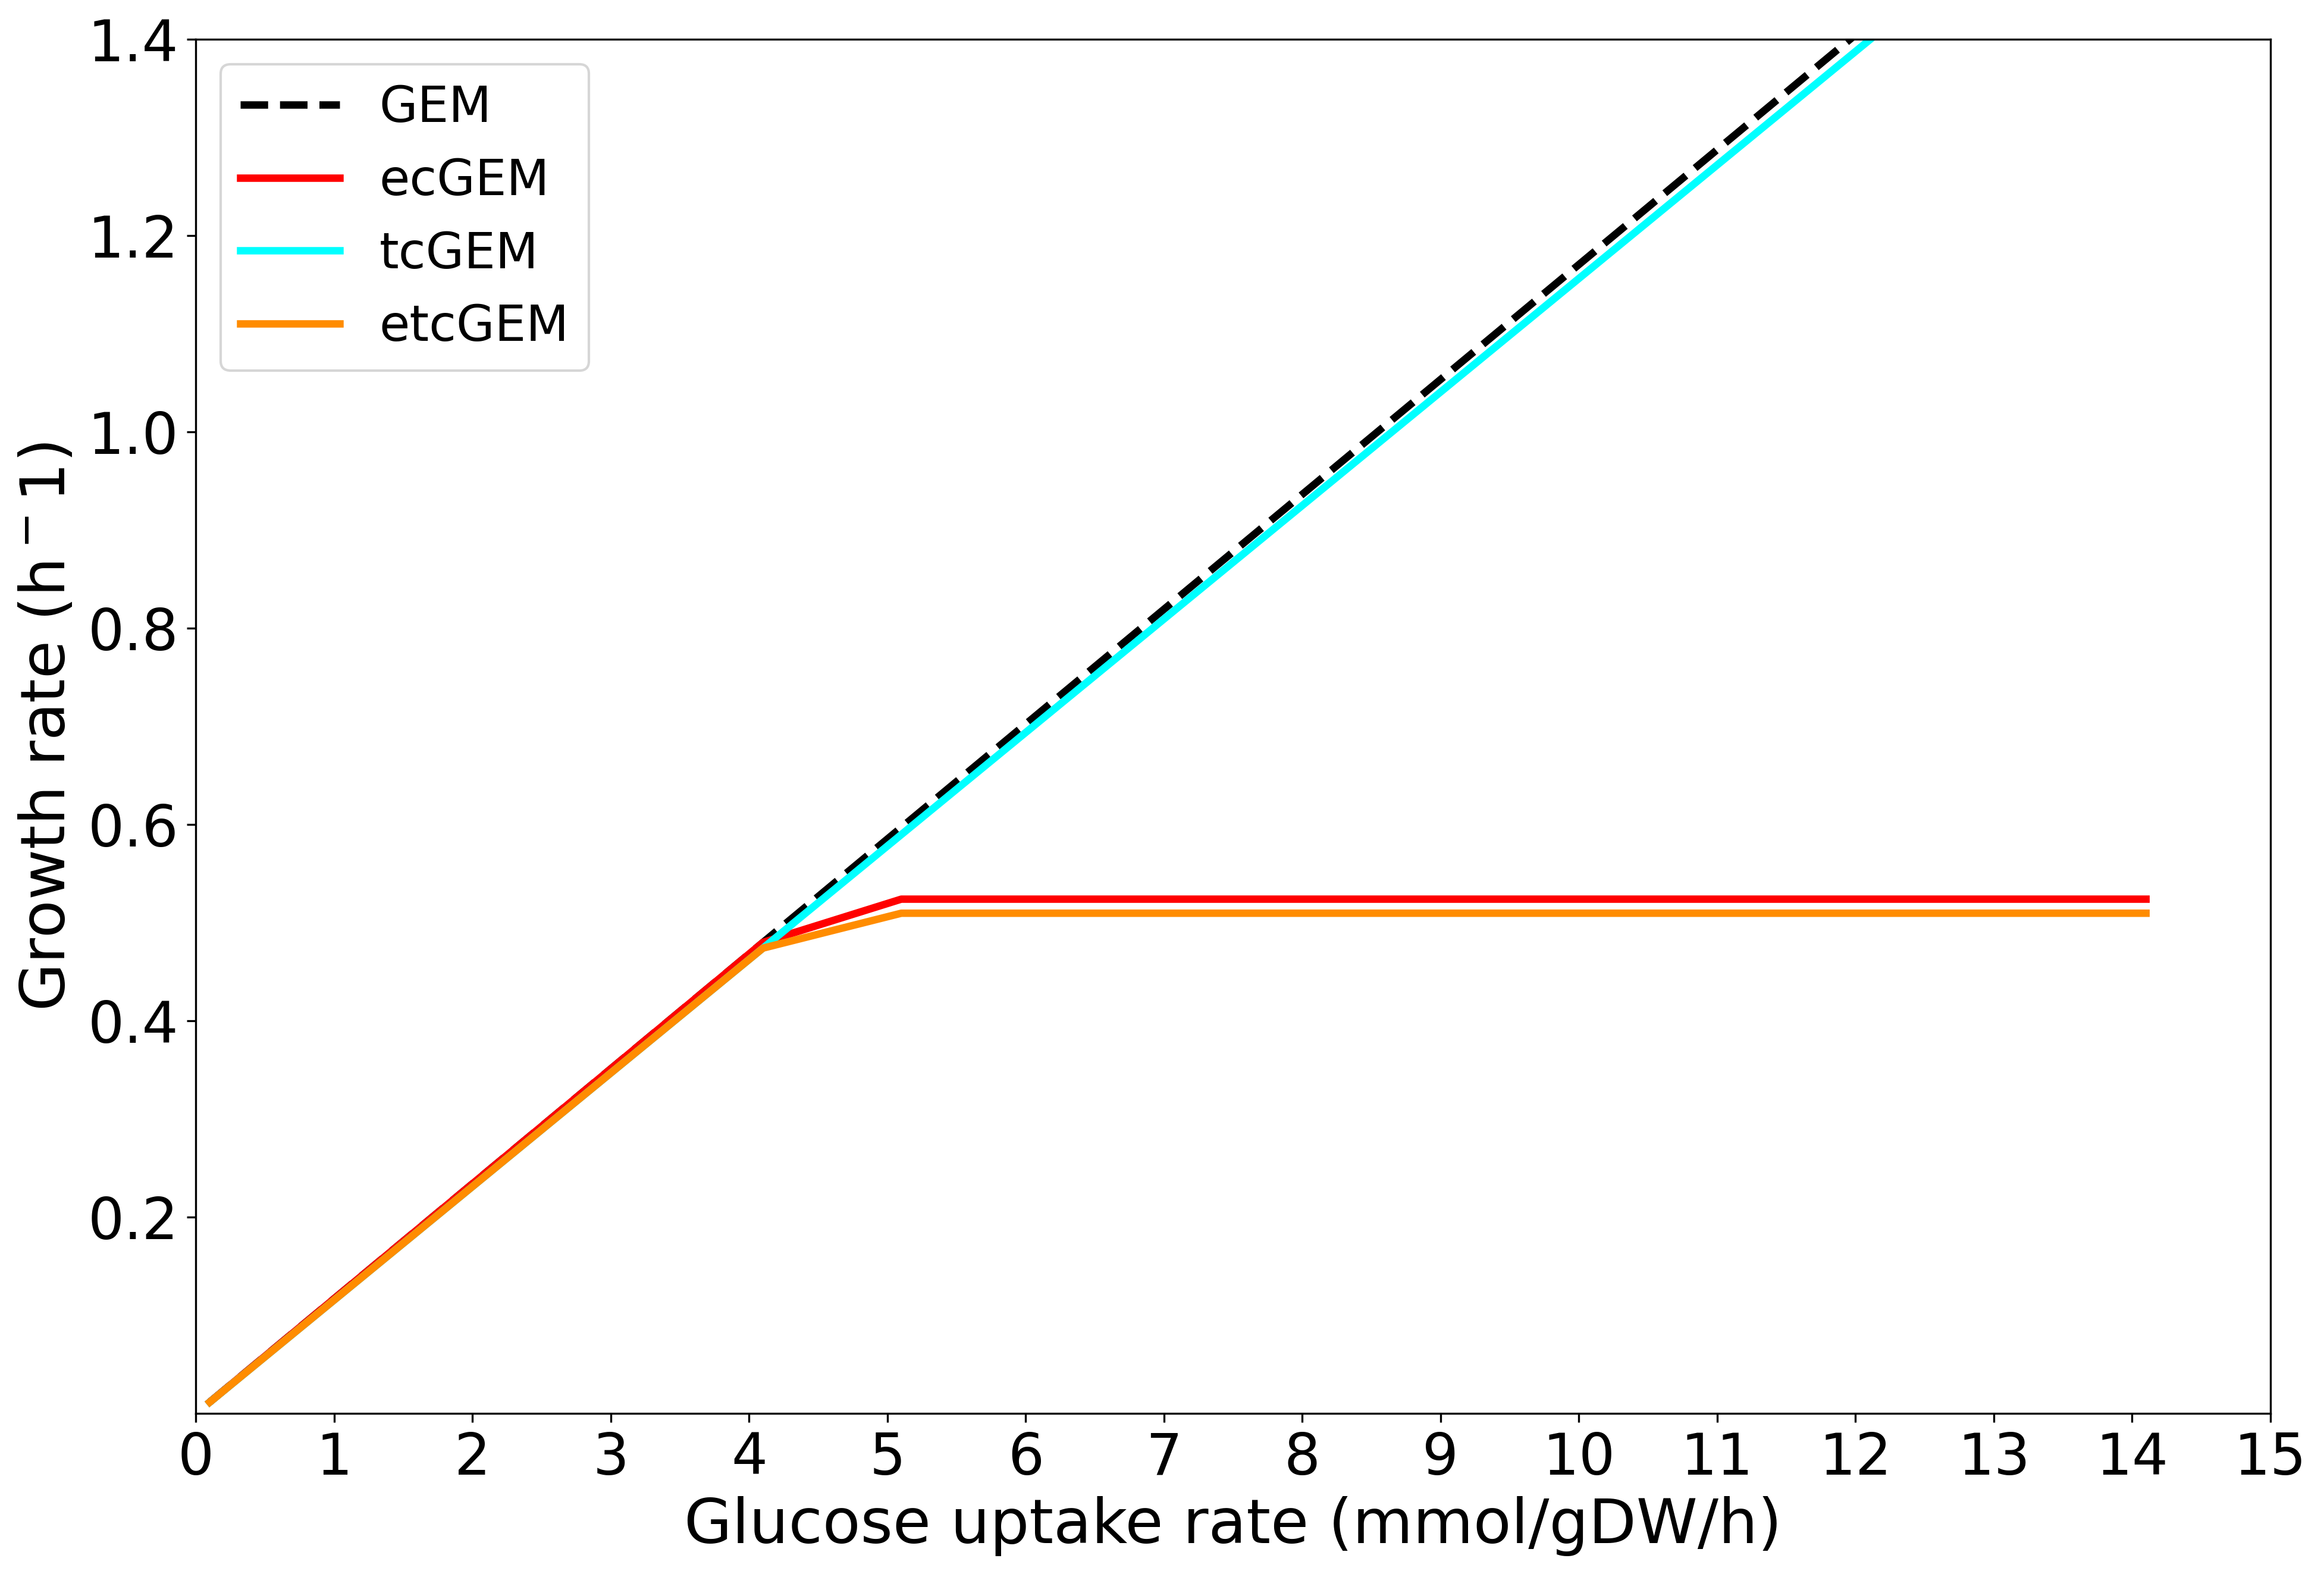

In [5]:
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'Times New Roman'
save_file="./analysis/figure/max_biomass_by_four_model_cg.png"
Draw_Biomass_By_Glucose_rate(Biomass_list,save_file)

# Comparison of C13 flux data

In [6]:
# In Silico Genome-Scale Reconstruction and Validation of the Corynebacterium glutamicum Metabolic Network
C13_flux = {}
C13_flux["GLCptspp"] = 1.0
C13_flux["PGI"] = 0.108
C13_flux["G6PDH2r"] = 0.885
C13_flux["PGL"] = 0.885
C13_flux["GND"] = 0.885
C13_flux["TKT1"] = 0.291
C13_flux["TALA"] = 0.270
C13_flux["TKT2"] = 0.291
C13_flux["PFK"] = 0.662
C13_flux["TPI"] = 0.662
C13_flux["GAPD_num1"] = 1.534
C13_flux["PGK"] = 1.534
C13_flux["PGM_num1"] = 1.534
C13_flux["ENO"] = 1.534
C13_flux["PPC"] = 0.203
C13_flux["PDH"] = 1.088
C13_flux["CS_num1"] = 0.75
C13_flux["ACONTa"] = 0.75
C13_flux["ACONTb"] = 0.75
C13_flux["ICDHyr"] = 0.75
C13_flux["AKGDH"] = 0.655
C13_flux["SUCOAS"] = 0.655
C13_flux["SUCDi"] = 0.655
C13_flux["FUM"] = 0.655
C13_flux["MDH"] = 0.655

In [7]:
c13_df = pd.DataFrame(list(C13_flux.items()), columns=['reaction', 'experiment'])
c13_df = c13_df.set_index("reaction")

In [8]:
substrate_value = 4.67
EcoGEM_combine = EcoGEM(Concretemodel_Need_Data_combine,obj_name,obj_target,substrate_name,substrate_value)
EcoECM_combine = EcoECM(Concretemodel_Need_Data_combine,obj_name,obj_target,substrate_name,substrate_value,E_total)
EcoTCM_combine = EcoTCM(Concretemodel_Need_Data_combine,obj_name,obj_target,substrate_name,substrate_value,K_value,B_value)
EcoETM_combine = EcoETM(Concretemodel_Need_Data_combine,obj_name,obj_target,substrate_name,substrate_value,E_total,K_value,B_value)
opt_EcoGEM_combine = Model_Solve(EcoGEM_combine, "cplex_direct")
opt_EcoECM_combine = Model_Solve(EcoECM_combine, "cplex_direct")
opt_EcoTCM_combine = Model_Solve(EcoTCM_combine, "cplex_direct")
opt_EcoETM_combine = Model_Solve(EcoETM_combine, "cplex_direct")


In [9]:
methods = ["GEM", "ecGEM", "tcGEM", "etcGEM"]
opt_dict = {
    "GEM": opt_EcoGEM_combine,
    "ecGEM": opt_EcoECM_combine,
    "tcGEM": opt_EcoTCM_combine,
    "etcGEM": opt_EcoETM_combine
}
model = cobra.io.load_json_model("./data/iCW773_retgems.json")
solution = model.optimize()
for index,row in c13_df.iterrows():
    for method in methods:
        opt_result = opt_dict[method]
        if "_num" in index:
            reaction_flux_result = 0
            for reaction in model.reactions:
                if index[:-1] in reaction.id:
                    reaction_flux_result += opt_result.reaction[reaction.id].value
        else:
            reaction_flux_result = opt_result.reaction[index].value
        c13_df.loc[index, method] = reaction_flux_result/opt_result.reaction["EX_glc_e_reverse"].value
    c13_df.loc[index, "GEM"] = solution.fluxes[index]/solution.fluxes["EX_glc_e_reverse"]

c13_df.to_csv("./analysis/C13_compare_central_for_mcmodel.csv")
c13_df.head()

,experiment,GEM,ecGEM,tcGEM,etcGEM
reaction,,,,,
GLCptspp,1.000,0.994412,1.000000,0.994480,1.000000
PGI,0.108,0.804609,0.442436,0.821522,0.463769
G6PDH2r,0.885,0.177615,0.540040,0.160918,0.518919
PGL,0.885,0.177615,0.540040,0.160918,0.518919
GND,0.885,0.177615,0.540040,0.160918,0.518919


In [10]:
c13_diff = c13_df.copy()
for index, row in c13_diff.iterrows():
    c13_diff.loc[index, "GEM"] = abs(row["GEM"] - row["experiment"])/row["experiment"]
    c13_diff.loc[index, "ecGEM"] = abs(row["ecGEM"] - row["experiment"])/row["experiment"]
    c13_diff.loc[index, "tcGEM"] = abs(row["tcGEM"] - row["experiment"])/row["experiment"]
    c13_diff.loc[index, "etcGEM"] = abs(row["etcGEM"] - row["experiment"])/row["experiment"]

c13_diff.head()

,experiment,GEM,ecGEM,tcGEM,etcGEM
reaction,,,,,
GLCptspp,1.000,0.005588,0.000000,0.005520,0.000000
PGI,0.108,6.450086,3.096626,6.606683,3.294162
G6PDH2r,0.885,0.799305,0.389785,0.818171,0.413651
PGL,0.885,0.799305,0.389785,0.818171,0.413651
GND,0.885,0.799305,0.389785,0.818171,0.413651


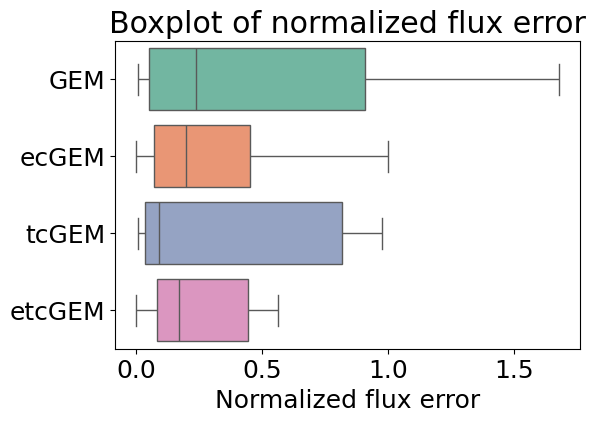

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
y_lab_len = len(c13_diff.columns)-1

c13_diff = c13_diff.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(6,y_lab_len))
sns.boxplot(data=c13_diff.drop(c13_diff.columns[0], axis=1), orient="h", palette="Set2", showfliers=False)
plt.title("Boxplot of normalized flux error")
plt.xlabel("Normalized flux error")
plt.savefig("./analysis/figure/diff_model_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print("GEM average relative error: "+str(np.mean(c13_diff['GEM'])))
print("ecGEM average relative error: "+str(np.mean(c13_diff['ecGEM'])))
print("tcGEM average relative error: "+str(np.mean(c13_diff['tcGEM'])))
print("etcGEM average relative error: "+str(np.mean(c13_diff['etcGEM'])))


GEM average relative error: 0.8916507710403679
ecGEM average relative error: 0.38578271926051594
tcGEM average relative error: 0.5290671295624576
etcGEM average relative error: 0.3924582139221408


# Calculate MDF

In [13]:
substrate_value = 4.67

[MDF_list, MDF_df] = calculate_MDF_list(Concretemodel_Need_Data_combine, obj_name, substrate_name, substrate_value, K_value, E_total, "./analysis/MDF_growth.csv")
MDF_df

0:00:23.541325


,MDF
0.100,3.035
0.110,3.035
0.432,3.035
0.442,2.425
0.451,2.425
0.461,0.856
0.510,0.856
0.520,-8.486
0.524,-8.486


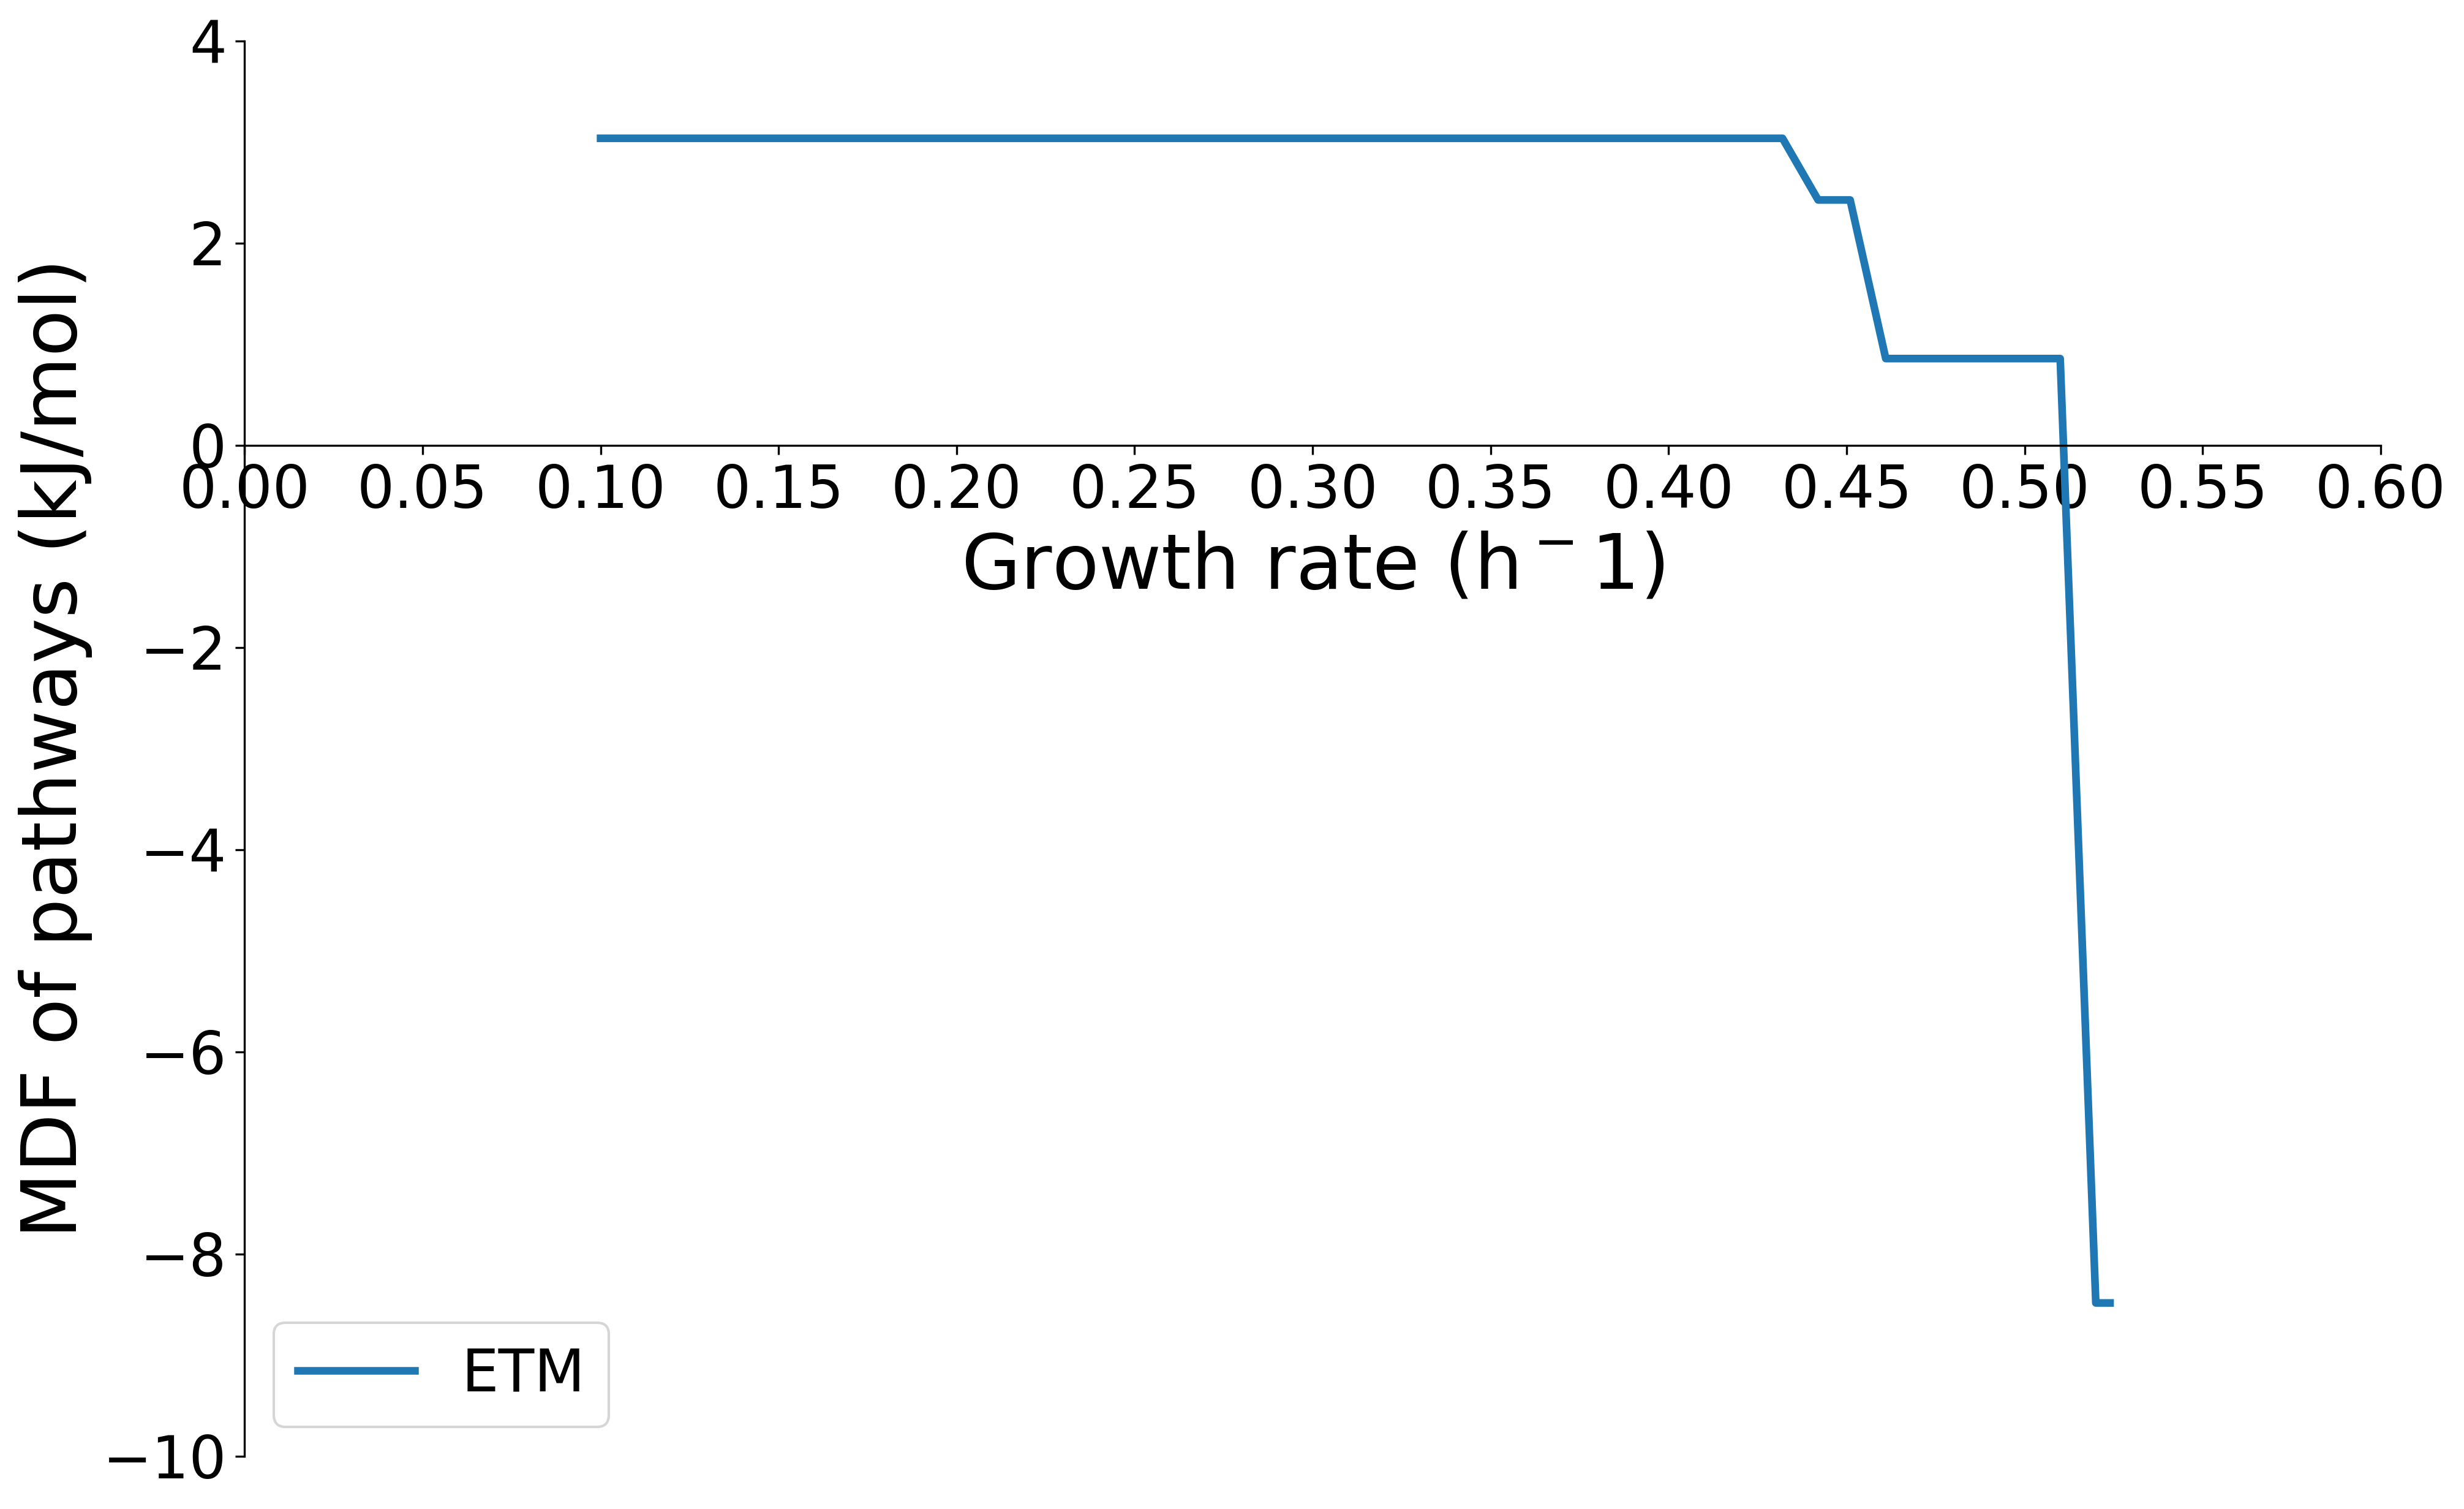

In [14]:
MDF_dict = {"ETM" : MDF_list}
# MDF_list = pd.read_csv(MDF_result_file, index_col=0)
#ytick = [ -2,0,2,4,6,8,10,12,14]
if MDF_df['MDF'].min()<0:
    ytick = list(np.arange(MDF_df['MDF'].min(), MDF_df['MDF'].max() + 2, 2))
else:
    ytick = list(np.arange(0, MDF_df['MDF'].max() + 2, 2))
ytick =[4,2,0,-2,-4,-6,-8,-10]   
png_file = "./analysis/figure/max_MDF_growth.png"
xlab = "Growth rate ($\mathregular{h^-1}$)"
# xlab = "Product rate (mmol/gDW/h)"
Draw_MDF_By_Product_rate(MDF_dict,0,xlab, 0.6,0.05,ytick,png_file)

# Solving the model based on the Mass Distribution Flux (MDF) curve.

In [15]:
etm1 = EcoETM(Concretemodel_Need_Data_combine,obj_name,obj_target,substrate_name,substrate_value,E_total,K_value,-8.5)
opt_etm1 = Model_Solve(etm1, "cplex_direct")
print(opt_etm1.obj())

0.5240173117210304


In [16]:
B_value1=MDF_Calculation(Concretemodel_Need_Data_combine,opt_etm1.obj(),obj_name,substrate_name,substrate_value,K_value,E_total,'cplex_direct')
print("B value1 : " +str(B_value1))
print()

B value1 : -8.486380882991336



In [17]:
obj_value = opt_etm1.obj()
B_value = B_value1

[min_V,Concretemodel]=Min_Flux_Sum_Calculation(Concretemodel_Need_Data_combine,obj_value,obj_name,substrate_name,substrate_value,K_value,E_total,B_value,'cplex_direct')
print("Min flux amount : " +str(min_V))

max_min_Df_list_fixed_file = './analysis/max_min_Df_complete_for_specific_reaction_cg_%s_%s_%s.csv'%(obj_name,obj_value,B_value)
Bottleneck_reaction_met_file = './analysis/Bottleneck_reaction_met_%s_%s_%s.csv'%(obj_name,obj_value,B_value)

max_min_concentration_list_fixed_file = './analysis/max_min_concentration_for_specific_metabolite_cg_%s_%s_%s.csv'%(obj_name,obj_value,B_value)
Limiting_metabolite_file = './analysis/Limiting_metabolite_%s_%s_%s.csv'%(obj_name,obj_value,B_value)

max_min_E_list_fixed_file = './analysis/max_min_E_cg_%s_%s_%s.csv'%(obj_name,obj_value,B_value)
Limiting_enzyme_file = './analysis/Limiting_enzyme_%s_%s_%s.csv'%(obj_name,obj_value,B_value)

model=Concretemodel_Need_Data_combine['model']
reaction_kcat_MW=Concretemodel_Need_Data_combine['reaction_kcat_MW']
reaction_g0=Concretemodel_Need_Data_combine['reaction_g0']
coef_matrix=Concretemodel_Need_Data_combine['coef_matrix']
metabolite_list=Concretemodel_Need_Data_combine['metabolite_list']
use_result = Get_Results_Thermodynamics(model,Concretemodel,reaction_kcat_MW,reaction_g0,coef_matrix,metabolite_list)
use_result = use_result[use_result['flux'] > 1e-10] 
use_result = use_result.sort_values(by = 'flux',axis = 0,ascending = False)
use_result["reaction"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).reaction, axis = 1)
use_result["gpr"] = use_result.apply(lambda row: model.reactions.get_by_id(row.name).gene_reaction_rule, axis = 1)
use_result.to_csv('./analysis/' + str(round(obj_value,3)) + '_' + str(round(B_value,3)) + '_CGETM.csv', sep=',', header=True, index=True,mode='w')

use_result_tmp=use_result[use_result['f']>-K_value]
use_result_select=use_result_tmp[abs(use_result_tmp['f']-B_value)<=1e-05]
use_result_select.head(10)

Min flux amount : 287.1068399105032


,flux,z,f,enz,met_concentration,reaction,gpr
PGK,7.003635,1.0,-8.486381,0.000778,;13dpg_c : 4.999999992621078e-07;3pg_c : 0.002...,13dpg_c + adp_c --> 3pg_c + atp_c,Cgl1587
GAPD_num1,7.003635,1.0,-8.486381,0.011833,;13dpg_c : 4.999999992621078e-07;g3p_c : 1.149...,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c,Cgl0937
TPI,3.176805,1.0,-8.486381,0.000004,;dhap_c : 3.903600076587464e-06;g3p_c : 1.1499...,dhap_c --> g3p_c,Cgl1586
ACONTa,2.734019,1.0,-8.486381,0.000381,;acon_C_c : 0.0004327114712983639;cit_c : 0.00...,cit_c --> acon_C_c + h2o_c,Cgl1540
FUM,2.519438,1.0,-8.486381,0.000376,;fum_c : 3.1852632791316176e-06;h2o_c : 1.0;ma...,fum_c + h2o_c --> mal__L_c,Cgl1010
PPKr_reverse,1.020073,1.0,-8.486381,-9999.000000,;adp_c : 7.4895658057503126e-06;atp_c : 7.4895...,adp_c + ppi_c --> atp_c + pi_c,
PGCD,0.361921,1.0,-8.486381,0.000020,;3pg_c : 0.0025809381554327167;3php_c : 7.4672...,3pg_c + nad_c --> 3php_c + h_c + nadh_c,Cgl1284
PRPPS,0.158245,1.0,-8.486381,0.000206,;amp_c : 7.4895658057503126e-06;atp_c : 7.4895...,atp_c + r5p_c --> amp_c + h_c + prpp_c,Cgl0942
MTHFD,0.132813,1.0,-8.486381,0.000023,;methf_c : 4.999999992621078e-07;mlthf_c : 1.5...,mlthf_c + nadp_c --> methf_c + nadph_c,Cgl0648
CBMKr,0.125536,1.0,-8.486381,-9999.000000,;adp_c : 7.4895658057503126e-06;atp_c : 7.4895...,atp_c + co2_c + nh4_c --> adp_c + cbp_c + 2.0 h_c,


In [18]:
starttime = datetime.datetime.now()
max_min_Df_list_fixed=pd.DataFrame()
path_reac_list=list(use_result_select.index)

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Get_Max_Min_Df_Complete,Concretemodel_Need_Data_combine,eachreaction,'maximize',K_value,B_value,obj_value,\
                               obj_name,E_total,substrate_name,substrate_value,'cplex_direct'): eachreaction for eachreaction in path_reac_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            #print(eachindex,tmp.loc[eachindex,'max_value'])
            max_min_Df_list_fixed.loc[eachindex,'max_Df_complete']=tmp.loc[eachindex,'max_value']

max_min_Df_list_fixed=max_min_Df_list_fixed.sort_values(by='max_Df_complete',ascending = True)
max_min_Df_list_fixed.to_csv(max_min_Df_list_fixed_file, sep=',', header=True, index=True,mode='w')

endtime = datetime.datetime.now()
print (endtime - starttime)
max_min_Df_list_fixed.head(10)

0:10:02.013105


,max_Df_complete
CBMKr,-8.486380
PPKr_reverse,2.250540
GLU5K,3.767088
PGCD,3.767088
ACGK,7.567088
GAPD_num1,9.586929
TPI,13.542375
MTHFD,15.890354
PGK,16.559691
ACONTa,18.128721


In [19]:
Bottleneck_reaction=max_min_Df_list_fixed[(max_min_Df_list_fixed['max_Df_complete']-B_value)<=0.001]
Bottleneck_reaction

,max_Df_complete
CBMKr,-8.48638
